In [1]:
# Etapa 1: Importação das bibliotecas

# Aqui estou importando todas as bibliotecas que vou usar no projeto.
# Incluem bibliotecas para manipulação de arrays e dados (NumPy, Pandas),
# visualização (Matplotlib), processamento de imagens (OpenCV),
# e as ferramentas de rede neural do TensorFlow/Keras.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence


2025-05-17 21:43:13.752505: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747518194.099779      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747518194.195600      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Etapa 2: Caminhos de arquivos no Kaggle

# No Kaggle, os arquivos já foram disponibilizados e descompactados,
# então não preciso fazer upload nem extrair zip manualmente.
# Aqui estou apenas definindo os caminhos para facilitar o uso depois.

base_path = "/kaggle/input/manufacturing-quality-control"
train_img_dir = os.path.join(base_path, "train")
test_img_dir = os.path.join(base_path, "test")

train_csv = os.path.join(base_path, "train.csv")
test_csv = os.path.join(base_path, "test.csv")
sample_submission_csv = os.path.join(base_path, "sample_submission.csv")


In [3]:
# Etapa 3: Carregamento e preparação dos dados

# Aqui estou lendo o arquivo train.csv com os dados de treino.
# Esse arquivo contém os nomes das imagens e os rótulos (0 ou 1) para cada tipo de defeito.

df = pd.read_csv("/kaggle/input/manufacturing-quality-control/train.csv")

# Substituo os valores NaN por 0, porque NaN indica que aquele defeito não está presente.
df.fillna(0, inplace=True)

# Converto todos os rótulos para inteiros (0 ou 1) para facilitar o treinamento
df.iloc[:, 1:] = df.iloc[:, 1:].astype(int)

# Visualizo as primeiras linhas para confirmar
df.head()


,id,CONTENT_HIGH,CONTENT_LOW,COVER_NONE,BOTTLE_SMASHED,LABEL_WHITE,LABEL_MISPLACED,LABEL_NONE,BOTTLE_NONE
0,train_1.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,train_2.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,train_3.jpg,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,train_4.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,train_5.jpg,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Etapa 4: Criando o gerador de imagens para o treinamento

# Aqui estou criando uma classe chamada BottleDataGenerator.
# Ela vai carregar as imagens da pasta train/ junto com os rótulos de defeitos do train.csv.

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random

# Parâmetros básicos
IMAGE_SIZE = (128, 128)  # tamanho para redimensionar as imagens
BATCH_SIZE = 16
IMAGE_PATH = "/kaggle/input/manufacturing-quality-control/train"  # caminho da pasta de imagens
LABELS = df.columns[1:].tolist()  # lista com os nomes das 8 colunas de defeitos

# Criando o gerador
class BottleDataGenerator(Sequence):
    def __init__(self, dataframe, batch_size, image_size, image_path, shuffle=True):
        self.df = dataframe.reset_index(drop=True)
        self.batch_size = batch_size
        self.image_size = image_size
        self.image_path = image_path
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.df))
        self.on_epoch_end()  # embaralha os dados

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        # Seleciona o batch da vez
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_df = self.df.iloc[batch_indexes]

        images = []
        labels = []

        for _, row in batch_df.iterrows():
            # Carrega a imagem e redimensiona
            img_path = os.path.join(self.image_path, row["id"])
            img = load_img(img_path, target_size=self.image_size)
            img_array = img_to_array(img) / 255.0  # normaliza os pixels (0–1)

            # Pega os rótulos da imagem atual
            label = row[LABELS].values.astype("float32")

            images.append(img_array)
            labels.append(label)

        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [5]:
# Criando o gerador de treinamento
train_gen = BottleDataGenerator(df, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, image_path=IMAGE_PATH)


In [6]:
# Etapa 5: Construção do modelo de rede neural (CNN)

# Aqui estou criando um modelo de rede neural convolucional simples com o Keras.
# Esse modelo recebe uma imagem RGB 128x128 e retorna 8 saídas,
# cada uma representando um defeito (0 = ausente, 1 = presente).

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Definindo a arquitetura do modelo
model = Sequential([
    # Primeira camada convolucional
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    # Segunda camada convolucional
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Terceira camada convolucional
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Camadas finais
    Flatten(),
    Dropout(0.5),              # Dropout para evitar overfitting
    Dense(128, activation='relu'),
    Dense(8, activation='sigmoid')  # 8 saídas com sigmoid para multilabel
])

# Compilando o modelo
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',   # porque é multilabel
              metrics=['accuracy'])

# Mostrando o resumo do modelo
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-17 21:43:33.864503: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,672 (12.61 MB)

 Trainable params: 3,305,672 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Etapa 6: Treinamento do modelo

# Aqui eu treino o modelo usando os dados de treino preparados com o BottleDataGenerator.
# Estou usando 20 épocas, mas esse valor pode ser ajustado dependendo do tempo de execução ou desempenho.

history = model.fit(train_gen, epochs=20)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 257ms/step - accuracy: 0.4449 - loss: 0.5153
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.6826 - loss: 0.3597
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.6544 - loss: 0.3136
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 240ms/step - accuracy: 0.6153 - loss: 0.3213
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.6149 - loss: 0.3025
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - accuracy: 0.7752 - loss: 0.2488
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 0.7416 - loss: 0.1905
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 0.8301 - loss: 0.1615
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 251ms/step - accuracy: 0.6114 - loss: 0.1219
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 0.7601 - loss: 0.0913
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.6668 - loss: 0.0798
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.6281 - lo

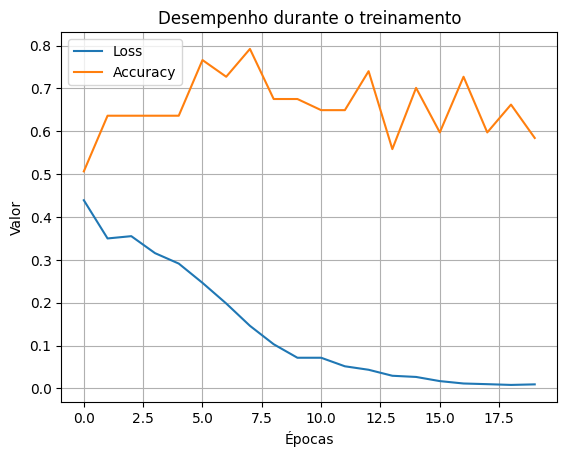

In [8]:
# Etapa 6.1: Curvas de perda (loss) e acurácia

# Aqui eu ploto como a loss e a acurácia evoluíram ao longo das épocas de treinamento.
# Isso ajuda a entender se o modelo está aprendendo ou sofrendo overfitting.

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['accuracy'], label='Accuracy')

plt.title('Desempenho durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Etapa 7: Função inspect_bottle(img)

# Aqui eu defino a função principal do projeto.
# Ela recebe uma imagem como array (em RGB), redimensiona para o tamanho esperado pelo modelo (128x128),
# normaliza os pixels (entre 0 e 1), e usa o modelo treinado para prever os defeitos.

def inspect_bottle(img):
    """
    Recebe uma imagem (numpy array RGB) e retorna um array com 8 valores binários (0 ou 1),
    indicando a presença ou ausência dos 8 defeitos na garrafa central.
    """
    # Verifica se a imagem está em RGB (3 canais)
    if img.shape[-1] != 3:
        raise ValueError("A imagem deve estar em RGB (3 canais).")

    # Redimensiona a imagem e normaliza os valores dos pixels
    resized = cv2.resize(img, (128, 128)) / 255.0
    resized = np.expand_dims(resized, axis=0)  # Adiciona uma dimensão para o batch

    # Faz a predição usando o modelo treinado
    prediction = model.predict(resized)[0]

    # Aplica um limiar de 0.5 para transformar em 0s e 1s
    return (prediction > 0.5).astype(np.float32)


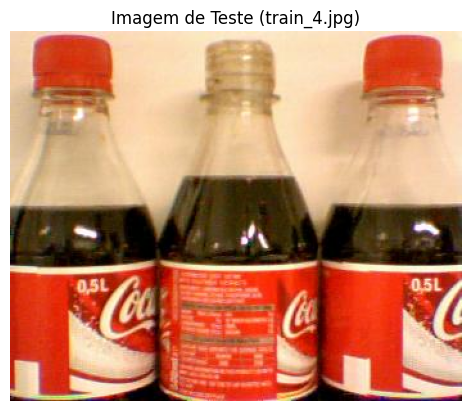

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
Resultado: [1. 0. 1. 0. 0. 0. 0. 0.]


In [10]:
# Etapa 7.1: Testando a função inspect_bottle com uma imagem real

# Aqui eu escolhi uma imagem do conjunto de treino (train_4.jpg) para testar a função inspect_bottle.
# Primeiro, leio a imagem usando o OpenCV e converto de BGR para RGB,
# depois passo a imagem para a função e imprimo o resultado (um vetor com 8 valores).

img_path = os.path.join("/kaggle/input/manufacturing-quality-control/train", "train_4.jpg")
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Mostra a imagem usada no teste
plt.imshow(img)
plt.axis("off")
plt.title("Imagem de Teste (train_4.jpg)")
plt.show()

# Aplica a função para detectar defeitos
output = inspect_bottle(img)
print("Resultado:", output)


In [11]:
# Etapa 8: Aplicando a função inspect_bottle em todas as imagens de teste

# Aqui estou percorrendo todas as imagens da pasta de teste e aplicando a função inspect_bottle.
# Para cada imagem, obtenho os 8 valores (0 ou 1) indicando os defeitos.
# Depois junto tudo em um DataFrame chamado submission_df.

import pandas as pd
import cv2
import numpy as np
import os
from tqdm import tqdm

# Caminhos dos arquivos no ambiente do Kaggle
test_csv_path = "/kaggle/input/manufacturing-quality-control/test.csv"
test_img_dir = "/kaggle/input/manufacturing-quality-control/test"

# Nomes das colunas de saída (os defeitos)
labels = ['CONTENT_HIGH','CONTENT_LOW','COVER_NONE','BOTTLE_SMASHED',
          'LABEL_WHITE','LABEL_MISPLACED','LABEL_NONE','BOTTLE_NONE']

# Carrego o arquivo com os nomes das imagens de teste
test_df = pd.read_csv(test_csv_path)
results = []

# Para cada imagem, aplico a função e salvo o resultado
for img_name in tqdm(test_df['id'], desc="Processando imagens"):
    img_path = os.path.join(test_img_dir, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    pred = inspect_bottle(img)  # Usa o modelo treinado
    row = [img_name] + pred.tolist()
    results.append(row)

# Cria o DataFrame com as colunas certas
submission_df = pd.DataFrame(results, columns=['id'] + labels)

# Mostra as 5 primeiras linhas como exemplo
submission_df.head()


Processando imagens:   0%|          | 0/64 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:   2%|▏         | 1/64 [00:00<00:07,  8.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:   3%|▎         | 2/64 [00:00<00:07,  8.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:   5%|▍         | 3/64 [00:00<00:07,  8.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:   6%|▋         | 4/64 [00:00<00:06,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:   8%|▊         | 5/64 [00:00<00:06,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:   9%|▉         | 6/64 [00:00<00:06,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  11%|█         | 7/64 [00:00<00:06,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processando imagens:  12%|█▎        | 8/64 [00:00<00:06,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  14%|█▍        | 9/64 [00:01<00:06,  8.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  16%|█▌        | 10/64 [00:01<00:06,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  17%|█▋        | 11/64 [00:01<00:06,  8.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  19%|█▉        | 12/64 [00:01<00:06,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processando imagens:  20%|██        | 13/64 [00:01<00:05,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  22%|██▏       | 14/64 [00:01<00:05,  8.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processando imagens:  23%|██▎       | 15/64 [00:01<00:05,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processando imagens:  25%|██▌       | 16/64 [00:01<00:05,  8.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  27%|██▋       | 17/64 [00:01<00:05,  8.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  28%|██▊       | 18/64 [00:02<00:05,  8.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  30%|██▉       | 19/64 [00:02<00:05,  8.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:  31%|███▏      | 20/64 [00:02<00:05,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  33%|███▎      | 21/64 [00:02<00:05,  8.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  34%|███▍      | 22/64 [00:02<00:04,  8.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  36%|███▌      | 23/64 [00:02<00:04,  8.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  38%|███▊      | 24/64 [00:02<00:04,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  39%|███▉      | 25/64 [00:02<00:04,  8.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  41%|████      | 26/64 [00:03<00:04,  8.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  42%|████▏     | 27/64 [00:03<00:04,  8.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


Processando imagens:  44%|████▍     | 28/64 [00:03<00:04,  8.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  45%|████▌     | 29/64 [00:03<00:04,  8.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  47%|████▋     | 30/64 [00:03<00:03,  8.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  48%|████▊     | 31/64 [00:03<00:03,  8.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  50%|█████     | 32/64 [00:03<00:03,  8.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processando imagens:  52%|█████▏    | 33/64 [00:03<00:03,  8.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processando imagens:  53%|█████▎    | 34/64 [00:03<00:03,  8.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  55%|█████▍    | 35/64 [00:04<00:03,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


Processando imagens:  56%|█████▋    | 36/64 [00:04<00:03,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  58%|█████▊    | 37/64 [00:04<00:03,  8.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:  59%|█████▉    | 38/64 [00:04<00:03,  8.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processando imagens:  61%|██████    | 39/64 [00:04<00:02,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


Processando imagens:  62%|██████▎   | 40/64 [00:04<00:02,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  64%|██████▍   | 41/64 [00:04<00:02,  8.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  66%|██████▌   | 42/64 [00:04<00:02,  8.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  67%|██████▋   | 43/64 [00:05<00:02,  8.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  69%|██████▉   | 44/64 [00:05<00:02,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:  70%|███████   | 45/64 [00:05<00:02,  8.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:  72%|███████▏  | 46/64 [00:05<00:02,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  73%|███████▎  | 47/64 [00:05<00:02,  8.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  75%|███████▌  | 48/64 [00:05<00:01,  8.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:  77%|███████▋  | 49/64 [00:05<00:01,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:  78%|███████▊  | 50/64 [00:05<00:01,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:  80%|███████▉  | 51/64 [00:05<00:01,  8.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processando imagens:  81%|████████▏ | 52/64 [00:06<00:01,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  83%|████████▎ | 53/64 [00:06<00:01,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:  84%|████████▍ | 54/64 [00:06<00:01,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  86%|████████▌ | 55/64 [00:06<00:01,  8.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processando imagens:  88%|████████▊ | 56/64 [00:06<00:00,  8.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:  89%|████████▉ | 57/64 [00:06<00:00,  8.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


Processando imagens:  91%|█████████ | 58/64 [00:06<00:00,  8.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:  92%|█████████▏| 59/64 [00:06<00:00,  8.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  94%|█████████▍| 60/64 [00:07<00:00,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


Processando imagens:  95%|█████████▌| 61/64 [00:07<00:00,  8.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Processando imagens:  97%|█████████▋| 62/64 [00:07<00:00,  8.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens:  98%|█████████▊| 63/64 [00:07<00:00,  8.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Processando imagens: 100%|██████████| 64/64 [00:07<00:00,  8.49it/s]


,id,CONTENT_HIGH,CONTENT_LOW,COVER_NONE,BOTTLE_SMASHED,LABEL_WHITE,LABEL_MISPLACED,LABEL_NONE,BOTTLE_NONE
0,test_1.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,test_2.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,test_3.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,test_4.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,test_5.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Etapa 9: Salvando o arquivo submission.csv

# Aqui estou salvando as predições no arquivo submission.csv.

submission_path = "/kaggle/working/submission.csv"
submission_df.to_csv(submission_path, index=False)

# Visualiza as 5 primeiras linhas para garantir que está no formato certo
submission_df.head()


,id,CONTENT_HIGH,CONTENT_LOW,COVER_NONE,BOTTLE_SMASHED,LABEL_WHITE,LABEL_MISPLACED,LABEL_NONE,BOTTLE_NONE
0,test_1.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,test_2.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,test_3.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,test_4.jpg,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,test_5.jpg,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
